In [98]:
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (Embedding, SpatialDropout1D, Bidirectional,
                                     LSTM, Conv1D, GlobalMaxPooling1D,
                                     Dense, Dropout, Input)
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [99]:
train_path = "train.csv"
test_path  = "test.csv"

df_train = pd.read_csv(train_path)
df_test  = pd.read_csv(test_path)

print(df_train.head())
print(df_train['class'].value_counts())


                                              tweets       class
0  Be aware  dirty step to get money  #staylight ...  figurative
1  #sarcasm for #people who don't understand #diy...  figurative
2  @IminworkJeremy @medsingle #DailyMail readers ...  figurative
3  @wilw Why do I get the feeling you like games?...  figurative
4  -@TeacherArthurG @rweingarten You probably jus...  figurative
class
figurative    21238
irony         20894
sarcasm       20681
regular       18595
Name: count, dtype: int64


In [100]:
df_train.dropna(subset=['tweets', 'class'], inplace=True)
df_test.dropna(subset=['tweets'], inplace=True)

eda

In [106]:
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'http\S+|www\.\S+', ' ', text)      # URL
    text = re.sub(r'@\w+', ' ', text)                  # mention
    text = re.sub(r'#', ' ', text)                     # buang simbol #
    text = re.sub(r'\s+', ' ', text)                   # spasi dobel
    text = text.strip()
    return text

df_train['clean_text'] = df_train['tweets'].apply(clean_text)
df_test['clean_text']  = df_test['tweets'].apply(clean_text)


In [107]:
le = LabelEncoder()
df_train['label_id'] = le.fit_transform(df_train['class'])

label2id = {label: idx for idx, label in enumerate(le.classes_)}
id2label = {idx: label for label, idx in label2id.items()}
print("Label mapping:", label2id)

X = df_train['clean_text'].values
y = df_train['label_id'].values

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


Label mapping: {'figurative': 0, 'irony': 1, 'regular': 2, 'sarcasm': 3}


In [108]:
max_words = 30000
max_len   = 40     # sedikit lebih panjang

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# train / val
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq   = tokenizer.texts_to_sequences(X_val)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad   = pad_sequences(X_val_seq,   maxlen=max_len, padding='post', truncating='post')

# test
X_test = df_test['clean_text'].values
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

vocab_size = min(max_words, len(tokenizer.word_index) + 1)
num_classes = len(le.classes_)

print("Vocab size:", vocab_size)
print("Num classes:", num_classes)


Vocab size: 30000
Num classes: 4


In [109]:
y = df_train['label_id']

classes = np.unique(y)
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y
)

class_weights = dict(zip(classes, class_weights))
print("Class Weight:", class_weights)


Class Weight: {0: 0.9582823241359827, 1: 0.9740595386235282, 2: 1.0944877655283678, 3: 0.9840916783521106}


In [110]:
embedding_dim = 200

inputs = Input(shape=(max_len,))

x = Embedding(
    input_dim=vocab_size,
    output_dim=embedding_dim,
    input_length=max_len
)(inputs)

x = SpatialDropout1D(0.4)(x)

# konteks sekuens
x = Bidirectional(LSTM(32, return_sequences=True))(x)

# filter n-gram
x = Conv1D(64, kernel_size=3, padding='same', activation='relu')(x)

x = GlobalMaxPooling1D()(x)

x = Dense(64, activation='relu')(x)
x = Dropout(0.6)(x)

outputs = Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=2e-3),
    metrics=['accuracy']
)

model.summary()


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 40)]              0         
                                                                 
 embedding_6 (Embedding)     (None, 40, 200)           6000000   
                                                                 
 spatial_dropout1d_6 (Spati  (None, 40, 200)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_6 (Bidirecti  (None, 40, 64)            59648     
 onal)                                                           
                                                                 
 conv1d_6 (Conv1D)           (None, 40, 64)            12352     
                                                                 
 global_max_pooling1d_6 (Gl  (None, 64)                0   

In [111]:
es = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

rlr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5
)

checkpoint = ModelCheckpoint(
    'best_cnn_bilstm.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True
)

history = model.fit(
    X_train_pad, y_train,
    validation_data=(X_val_pad, y_val),
    epochs=25,
    batch_size=128,
    class_weight=class_weights,
    callbacks=[es, rlr, checkpoint],
    verbose=1
)

model.load_weights('best_cnn_bilstm.h5')


Epoch 1/25
509/509 [==============================] - 50s 89ms/step - loss: 0.5568 - accuracy: 0.7125 - val_loss: 0.4970 - val_accuracy: 0.7384 - lr: 0.0020
Epoch 2/25
509/509 [==============================] - 42s 82ms/step - loss: 0.4861 - accuracy: 0.7383 - val_loss: 0.5000 - val_accuracy: 0.7389 - lr: 0.0020
Epoch 3/25
509/509 [==============================] - 41s 81ms/step - loss: 0.4824 - accuracy: 0.7380 - val_loss: 0.5058 - val_accuracy: 0.7386 - lr: 0.0020
Epoch 4/25
509/509 [==============================] - 41s 80ms/step - loss: 0.4645 - accuracy: 0.7390 - val_loss: 0.5493 - val_accuracy: 0.7346 - lr: 0.0010
Epoch 5/25
509/509 [==============================] - 41s 81ms/step - loss: 0.4432 - accuracy: 0.7429 - val_loss: 0.5905 - val_accuracy: 0.7114 - lr: 0.0010


In [112]:
def predict_emotion(text: str):
    """
    Input: text mentah (string)
    Output: (label_pred, probs_array)
    """

    
    cleaned = clean_text(text)
    seq = tokenizer.texts_to_sequences([cleaned])
    pad = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    
    probs = model.predict(pad)[0]
    pred_id = probs.argmax()
    pred_label = id2label[pred_id]
    
    return pred_label, probs

# contoh pakai:
sample_text = "And now to make this game even better, itâ€™s time for the wave!  #sarcasm  #Eyeroll  #DieWaveDie"
label, probs = predict_emotion(sample_text)
print("Teks :", sample_text)
print("Prediksi kelas :", label)
print("Prob tiap kelas :", dict(zip(le.classes_, np.round(probs, 3))))


1/1 [==============================] - 1s 883ms/step
Teks : And now to make this game even better, itâ€™s time for the wave!  #sarcasm  #Eyeroll  #DieWaveDie
Prediksi kelas : sarcasm
Prob tiap kelas : {'figurative': 0.337, 'irony': 0.0, 'regular': 0.0, 'sarcasm': 0.663}


In [113]:
print("\n=== MODE PREDIKSI MANUAL ===")
print("Ketik 'q' untuk keluar.\n")

while True:
    txt = input("Masukkan kalimat: ")
    if txt.lower() == 'q':
        print("Selesai.")
        break
    
    label, probs = predict_emotion(txt)
    print(f"Prediksi kelas: {label}")
    print("Probabilitas:")
    for cls, p in zip(le.classes_, probs):
        print(f"  {cls:10s}: {p:.3f}")
    print("-" * 40)



=== MODE PREDIKSI MANUAL ===
Ketik 'q' untuk keluar.

1/1 [==============================] - 0s 29ms/step
Prediksi kelas: sarcasm
Probabilitas:
  figurative: 0.330
  irony     : 0.000
  regular   : 0.000
  sarcasm   : 0.670
----------------------------------------
1/1 [==============================] - 0s 31ms/step
Prediksi kelas: sarcasm
Probabilitas:
  figurative: 0.330
  irony     : 0.000
  regular   : 0.000
  sarcasm   : 0.670
----------------------------------------
Selesai.


In [114]:
import json
import pickle
from tensorflow.keras.preprocessing.text import Tokenizer

# --- SIMPAN TOKENIZER (Sel di Notebook) ---
tokenizer_json = tokenizer.to_json()
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)
print("Tokenizer berhasil disimpan.")

# --- SIMPAN LABEL ENCODER (Sel di Notebook) ---
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f) # le adalah objek LabelEncoder Anda
print("LabelEncoder berhasil disimpan.")

Tokenizer berhasil disimpan.
LabelEncoder berhasil disimpan.


In [115]:
from sklearn.metrics import f1_score, classification_report

# 1. Prediksi di data validasi
y_val_probs = model.predict(X_val_pad)
y_val_pred  = y_val_probs.argmax(axis=1)

# 2. F1-score (macro & weighted)
f1_macro    = f1_score(y_val, y_val_pred, average='macro')
f1_weighted = f1_score(y_val, y_val_pred, average='weighted')

print("F1-score (macro)   :", f1_macro)
print("F1-score (weighted):", f1_weighted)

# 3. (opsional) classification report per kelas
print("\nClassification report:")
print(classification_report(y_val, y_val_pred, target_names=le.classes_))


509/509 [==============================] - 3s 7ms/step
F1-score (macro)   : 0.6478651856147192
F1-score (weighted): 0.6348044975268651

Classification report:
              precision    recall  f1-score   support

  figurative       0.11      0.00      0.00      4248
       irony       0.66      1.00      0.80      4179
     regular       1.00      1.00      1.00      3719
     sarcasm       0.66      1.00      0.80      4136

    accuracy                           0.74     16282
   macro avg       0.61      0.75      0.65     16282
weighted avg       0.60      0.74      0.63     16282



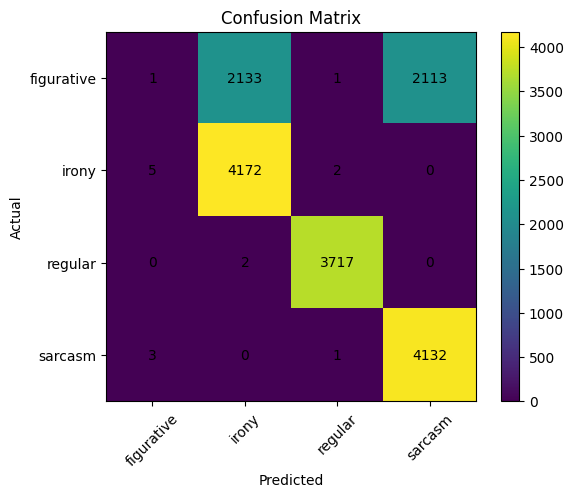

In [116]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_val_pred)

plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.colorbar()
plt.xlabel("Predicted")
plt.ylabel("Actual")

tick_marks = range(len(le.classes_))
plt.xticks(tick_marks, le.classes_, rotation=45)
plt.yticks(tick_marks, le.classes_)

for i in range(len(cm)):
    for j in range(len(cm[0])):
        plt.text(j, i, cm[i, j], ha='center', va='center')

plt.show()
